# Problem Set #11

**Tc2037 Implementation of Computational Methods**

April 15, 2021.

_Authors of this notebook’s solution:_

- _Student ID and Name:_
- _Student ID and Name:_

**Instructions:** Follow the indications contained in this notebook. Complete the code where required.

In [2]:
;; External function required for this notebook.
(require '[clojure.test :refer [is]])

nil

## Non-deterministic Finite Automaton (NFA)

In a NFA, for a particular input symbol, the machine can move to any combination of the states in the machine. In other words, the exact state to which the machine moves cannot be determined. Hence, it is called _Non-deterministic Automaton_. As it has finite number of states, the machine is called _Non-deterministic Finite Automaton_.

A NFA can de represented by a _state diagram_ or by the 5-tuple $(Q, \Sigma, \delta, q_0, F)$:

* $Q$ is a finite set of states.  
* $\Sigma$ is a finite set of symbols, called the _alphabet_ of the automaton.
* $\delta$ is the transition function: $Q \times \Sigma \to \mathcal{P}(Q)$, where $\mathcal{P}(Q)$ is the power set of $Q$.
* $q_0$ is the initial state from where any input is processed ($q_0 \in Q$).
* $F$ is a set of final states ($F \subseteq  Q$). 

### NFA Example

We want a finite automaton that accepts strings that contain a sequence of symbols `a` and `b` but where the third-from-last character is `b`.

The following state diagram achieves this:

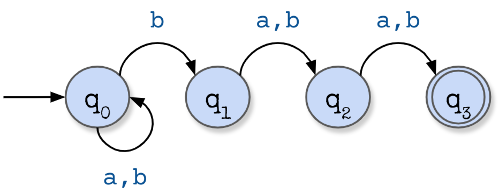

Thus, the formal definition of the NFA is as follows:

* $Q = \{ q_0, q_1, q_2, q_3 \}$   
* $\Sigma = \{ a, b\}$
* $q_0 =$ Initial state
* $F = \{ q_3 \}$
* This table shows the transition function $\delta$:

| Current State | Next state for input $a$ | Next state for input $b$ |
|:-------------:|:------------------------:|:------------------------:|
|     $q_0$     |           $q_0$          |        $q_0, q_1$        |
|     $q_1$     |           $q_2$          |           $q_2$          |
|     $q_2$     |           $q_3$          |           $q_3$          |

### DFA vs NFA

The following table lists the differences between DFA and NFA.

| DFA | NFA |
|-----|-----|
|For each symbolic representation of the alphabet, there is only one state transition.|No need to specify how the machine reacts according to some symbol.|
|Cannot use an empty string transition.|Can use an empty string transition.|
|Can be understood as one machine.|Can be understood as multiple little machines computing at the same time.|
|The next possible state is distinctly set.|Each pair of state and input symbol can have many possible next states.|
|More difficult to construct.|Easier to construct.|
|Rejects a string in case it terminates in a state that is different from the accepting state.|Rejects a string in the event of all branches dying or refusing it.|
|Less time needed for executing an input string.|More time needed for executing an input string.|
|All DFAs are NFAs.|Not all NFAs are DFAs.|
|Requires more space.|Requires less space.|
|Dead state may be required.|No dead state required.|
|$\delta: Q \times \Sigma \to Q$, i.e. next possible state belongs to $Q$.|$ \delta: Q \times \Sigma \to \mathcal{P}(Q)$, i.e. next possible state belongs to power set of $Q$.|

[Source.](https://www.geeksforgeeks.org/difference-between-dfa-and-nfa/)

### Exercise 1

Design a NFA with $\Sigma = \{ 0, 1 \}$ that accepts all strings ending with $111$. Your solution must include the state diagram and the formal definition.

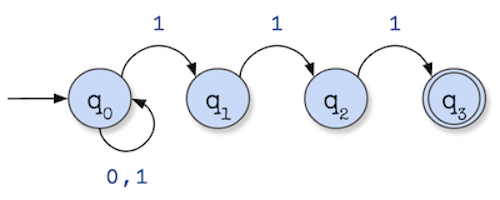

### Exercise 2

Design a NFA with $\Sigma = \{ x, y \}$ that accepts all strings that contain the subsequence $xxyy$. Your solution must include the state diagram and the formal definition.

## NFA Simulation

We need some of the code we used before when simulating DFAs. 

In [3]:
(defrecord Rule [state character next-state])

(defn applies-to?
  [rule state character]
  (and (= (:state rule) state)
       (= (:character rule) character)))

(defn follow
  [rule]
  (:next-state rule))

#'user/follow

The transition function for a NFA will be represented as a vector of `Rule` objects, which will be referred as a _rulebook_. For the previous NFA example it would look like this:

In [4]:
(def rb-example1 [(->Rule 0 \a 0) 
                  (->Rule 0 \b 0) 
                  (->Rule 0 \b 1)
                  (->Rule 1 \a 2) 
                  (->Rule 1 \b 2)
                  (->Rule 2 \a 3) 
                  (->Rule 2 \b 3)])

#'user/rb-example1

Remember that for a given rule, the `applies-to?` function returns `true` or `false` to indicate whether that rule applies in a particular situation given a specific state and character. The `rules-for` function uses `applies-to?` in order to find in a rulebook all the rules that can be applied to a state and character. The result is a (possible empty) sequence of these rules. 

In [5]:
(defn rules-for
  [rulebook state character]
  (filter #(applies-to? % state character) rulebook))

#'user/rules-for

In [6]:
(let [r1 (->Rule 0 \a 0) 
      r2 (->Rule 0 \b 0) 
      r3 (->Rule 0 \b 1)]
  (is (= [r1] (rules-for rb-example1 0 \a)))
  (is (= [r2 r3] (rules-for rb-example1 0 \b)))
  (is (= [] (rules-for rb-example1 3 \a))))

true

Also, recall that the `follow` function returns the state that the machine should change to when a rule is followed. The function `follow-rules-for` applies `follow` to each element returned by `rules-for`, returning a (possible empty) sequence of states.

In [7]:
(defn follow-rules-for
  [rulebook state character]
  ;;; your code goes here
  (map follow (rules-for rulebook state character)))

#'user/follow-rules-for

In [8]:
(is (= [0] (follow-rules-for rb-example1 0 \a)))
(is (= [0 1] (follow-rules-for rb-example1 0 \b)))
(is (= [] (follow-rules-for rb-example1 3 \a)))

true

The `next-states` will use the `follow-rules-for` function to obtain a (possible empty) set of all the states that can be followed from a given set of states and a specific character.

In [9]:
(defn next-states
  [rulebook states character]
  (set (mapcat #(follow-rules-for rulebook % character) states)))

#'user/next-states

In [10]:
(next-states rb-example1 #{0 1} \a)

#{0 2}

In [11]:
(is (= #{0 1} (next-states rb-example1 #{0} \b)))
(is (= #{0 2} (next-states rb-example1 #{0 1} \a)))
(is (= #{0 1 3} (next-states rb-example1 #{0 2} \b)))
(is (= #{} (next-states rb-example1 #{3} \a)))
(is (= #{0 2 3} (next-states rb-example1 #{0 1 2 3} \a)))

true

We now define a record to represent a non-deterministic finite automaton.

In [ ]:
(defrecord NFA [current-states accept-states rulebook])

The `current-states` function returns the set in the current states field of a given NFA record. We define it as a function because it will get more elaborate in the future.

In [ ]:
(defn current-states
  [nfa]
  ;;; your code goes here
  nil)

In [ ]:
(let [n1 (->NFA #{0 1} #{3} rb-example1)
      n2 (->NFA #{0} #{3} rb-example1)]
  (is (= #{0 1} (current-states n1)))
  (is (= #{0} (current-states n2))))

The `accepting?` function returns `true` if the given NFA is in an accepting state, or `false` otherwise. An NFA is in an accepting state if there is at least one state in the current states set that is also contained in the accepting states set.

In [ ]:
(defn accepting?
  [nfa]
  ;;; your code goes here
  nil)

In [ ]:
(let [n1 (->NFA #{0 3} #{3} rb-example1)
      n2 (->NFA #{0} #{3} rb-example1)]
  (is (accepting? n1))
  (is (not (accepting? n2))))

The `process-character` function takes an NFA and an input character. It returns a new NFA which is a copy of the provided NFA but with its current states field updated with the result of the `next-states` function.

In [ ]:
(defn process-character
  [nfa character]
  ;;; your code goes here
  nil)

In [ ]:
(let [n1 (->NFA #{0} #{3} rb-example1)
      n2 (->NFA #{0 1} #{3} rb-example1)
      n3 (->NFA #{0 1 2} #{3} rb-example1)]
  (is (= n2 (process-character n1 \b)))
  (is (= n1 (process-character n1 \a)))
  (is (= n3 (process-character n2 \b))))

The `accepts?` function takes a NFA and an input string. It returns `true` if the DFA accepts the given string or `false` otherwise.

In [ ]:
(defn accepts?
  [nfa input]
  ;;; your code goes here
  nil)

In [ ]:
(let [n (->NFA #{0} #{3} rb-example1)]
  (is (accepts? n "bab"))
  (is (accepts? n "bbbbb"))
  (is (accepts? n "bbaaabbabaa"))
  (is (not (accepts? n "")))
  (is (not (accepts? n "abababababa")))
  (is (not (accepts? n "bbbbbbbbbbbbbbabb"))))

### Exercise 3

Simulate in code the NFA you designed for exercise 1 and write unit tests that check the following strings:

1. Accepts: $111$
2. Accepts: $1111111$
3. Accepts: $00000000111$
4. Accepts: $10110101001000111$
5. Rejects: $\varepsilon$
6. Rejects: $11$
7. Rejects: $1111110$
8. Rejects: $10111011011$

In [ ]:
;;; your unit tests go here

### Exercise 4

Simulate in code the NFA you designed for exercise 2 and write unit tests with the following strings:

1. Accepts: $xxyy$
2. Accepts: $xxxxxxxxyy$
3. Accepts: $xxyyyyyyyy$
4. Accepts: $xyxyxyxxyyxyxyxy$
5. Rejects: $\varepsilon$
6. Rejects: $yyxx$
7. Rejects: $xyxyxyxyxyxyxyx$
8. Rejects: $xxyxxyxxyxyyxyyxyy$

In [ ]:
;;; your unit tests go here